TalkingData AdTracking Fraud Detection
==============
*Luiz Sampaio e Rodrigo Escorcio* - Prof: Renato Souza

Team Name: *GoOttawa*

Objetiva-se fazer uma análise preditiva dos dados da competição "TalkingData AdTracking Fraud Detection Challenge" do Kaggle (https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection)

Os dados consistem de informações para cada click, como: IP, o aplicativo que estava sendo utilizado, o aparelho utilizado, a versão do sistema operacional do aparelho, o horário do click, se o usuário de fato fez o download e que horas foi feito.

In [2]:
# Importando bibliotecas

import os
import sys
import time
import pickle
import itertools
import pandas as pd
import numpy as np
import pylab

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Pré-Processamento dos Dados
-------

A primeira fase consiste no pré-processamento dos dados para posterior análise preditiva. Como os dados estão codificados, é necessário algumas técnicas de pré-processamento para evitar problemas ao usar os modelos preditivos.

*Importando os dados*

In [3]:
csvtrain = "train.csv"
csvtest = "test.csv" #declarar (utilizamos uma parcela dos dados, já que nao foi possivel rodar na maquina virtual) 

In [4]:
df_train = pd.read_csv(csvtrain) #importar dados

df_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,70335,3,1,8,130,07/11/2017,04:21:42,0
1,357443,15,1,13,265,09/11/2017,02:02:34,0
2,37515,13,1,37,477,06/11/2017,22:55:26,0
3,3219,9,1,19,215,07/11/2017,04:00:26,0
4,61800,15,1,9,130,09/11/2017,03:19:46,0


Utilizaremos One-Hot-Encoding para os dados codificados para evitar que os modelos entendam as codificações como valores e acabem tirando conclusões equivocadas sobre os dados.

In [5]:
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
lb = LabelBinarizer()
mlb = MultiLabelBinarizer()

In [6]:
num = df_train['app'].values
N = np.shape(np.unique(num))[0] 

lista = []
for i in range(N):
    lista.append('app'+str(i))
    
apps = pd.DataFrame(lb.fit_transform(df_train['app'].values),columns=lista)
df_train = pd.concat([df_train,apps], axis=1)

In [7]:
num = df_train['device'].values
M = np.shape(np.unique(num))[0] 

lista = []
for i in range(M):
    lista.append('device'+str(i))

devices = pd.DataFrame(lb.fit_transform(df_train['device'].values),columns=lista)
df_train = pd.concat([df_train,devices], axis=1)

In [8]:
num = df_train['os'].values
O = np.shape(np.unique(num))[0] 

lista = []
for i in range(O):
    lista.append('os'+str(i))

oss = pd.DataFrame(lb.fit_transform(df_train['os'].values),columns=lista)
df_train = pd.concat([df_train,oss], axis=1)

In [9]:
num = df_train['channel'].values
P = np.shape(np.unique(num))[0] 

lista = []
for i in range(P):
    lista.append('channel'+str(i))

channels = pd.DataFrame(lb.fit_transform(df_train['channel'].values),columns=lista)
df_train = pd.concat([df_train,channels], axis=1)

In [10]:
tmp = df_train['attributed_time']
tmp2 = tmp.tolist()
lista = []
for time in tmp2:
    stime = time.split(":")
    lista.append((int(stime[0])*3600+int(stime[1])*60+int(stime[2]))/86400.0)

times = pd.DataFrame(lista,columns=["attr_time"])
df_train = pd.concat([df_train,times], axis=1)

tmp3 = df_train['is_attributed']
tmp4 = tmp3.tolist()
lista = []
for time in tmp4:
    if time!='0':
        stime = 1
    else:
        stime = int(time)
    lista.append(stime)

times = pd.DataFrame(lista,columns=["is_attr"])
df_train = pd.concat([df_train,times], axis=1)

df_train2 = df_train.drop(['ip','app','device','os','channel','click_time','attributed_time','is_attributed'], axis=1)

Aqui, são criadas funções para ajudar no cálculo da AUC da ROC e também para facilitar a visualização da resposta dos modelos.

In [70]:
from sklearn import model_selection

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def clf_eval(clf, X, y_true, classes=['Fraudulento', 'Nao fraudulento']):
    y_pred = clf.predict(X)
    clf_matrix = confusion_matrix(y_true, y_pred)
    print('Classification Report')
    print(classification_report(y_true, y_pred, target_names=classes))
    print('ROC Score: {}'.format(roc_auc_score(y_true, y_pred)))
    print('Accuracy Score: {}'.format(accuracy_score(y_true, y_pred)))
    print('Average Precision Score: {}'.format(average_precision_score(y_true, y_pred)))
    print('f1 Score: {}'.format(f1_score(y_true, y_pred)))
    plot_confusion_matrix(clf_matrix, classes=classes)
    return roc_auc_score(y_true, y_pred)

In [12]:
# Vou pegar só alguns pontos, depois tem que mudar!!!!

train_data = df_train2.values
X_train = train_data[0:4000,0:-1]
y_train = train_data[0:4000,-1]


#### ATENÇÃO ####

*Separando os dados para Cross-validation*

In [13]:
X_traincv, X_testcv, y_traincv, y_testcv = model_selection.train_test_split(X_train,
                                                                            y_train,
                                                                            test_size=0.2,
                                                                            random_state=0)

print(X_traincv.shape)
print(X_testcv.shape)
print(y_traincv.shape)
print(y_testcv.shape)

(3200, 553)
(800, 553)
(3200,)
(800,)


Observe que os dados não estão balanceados.

In [14]:
print(len(y_traincv[y_traincv == 0]))
print(len(y_traincv[y_traincv == 1]))

3194
6


Pode-se então fazer um oversampling da classe minoritária.

In [15]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(kind='regular')
X_traincv_res, y_traincv_res = smote.fit_sample(X_traincv, y_traincv)

print(len(y_traincv_res[y_traincv_res == 0]))
print(len(y_traincv_res[y_traincv_res == 1]))

3194
3194


Análise Preditiva dos Dados
-------

Neste tópico, utilizaremos os dados em diversos modelos preditivos para posterior análise dos resultados.

**Support Vector Machine**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      0.98      0.99       798
    Sobreviveu       0.12      1.00      0.21         2

   avg / total       1.00      0.98      0.99       800

ROC Score: 0.9906015037593985
Accuracy Score: 0.98125
Average Precision Score: 0.11764705882352941
f1 Score: 0.21052631578947367
Confusion matrix, without normalization
[[783  15]
 [  0   2]]


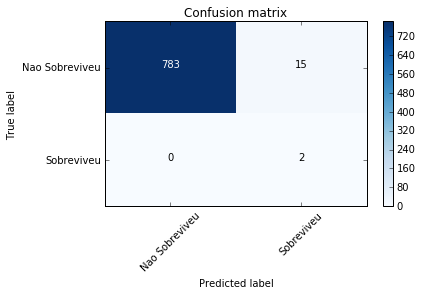

In [16]:
from sklearn import svm

clf_svc2 = svm.SVC(kernel='poly',
                   C=2.0,
                   degree=4, 
                   gamma=0.0001, 
                   coef0=0.0, 
                   shrinking=True, 
                   probability=False, 
                   tol=0.001, 
                   cache_size=200, 
                   class_weight=None, 
                   verbose=False, 
                   max_iter=-1, 
                   random_state=0).fit(X_traincv_res, y_traincv_res)

roc_svc2 = clf_eval(clf_svc2, X_testcv, y_testcv)

**Logistic Regression**

Classification Report
                 precision    recall  f1-score   support

    Fraudulento       1.00      0.98      0.99       798
Nao fraudulento       0.12      1.00      0.22         2

    avg / total       1.00      0.98      0.99       800

ROC Score: 0.9912280701754386
Accuracy Score: 0.9825
Average Precision Score: 0.125
f1 Score: 0.2222222222222222


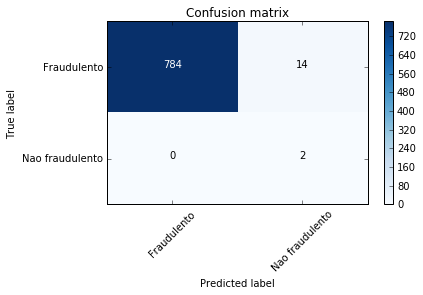

In [71]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            dual=False, 
                            tol=0.001, 
                            C=0.10, 
                            fit_intercept=True, 
                            intercept_scaling=1, 
                            class_weight=None, 
                            random_state=0, 
                            solver='saga', 
                            max_iter=100, 
                            multi_class='ovr', 
                            verbose=0, 
                            warm_start=False, 
                            n_jobs=-1).fit(X_traincv_res, y_traincv_res)

roc_lr = clf_eval(clf_lr, X_testcv, y_testcv)

**Ridge Classifier**

Classification Report
                 precision    recall  f1-score   support

    Fraudulento       1.00      0.97      0.98       798
Nao fraudulento       0.08      1.00      0.14         2

    avg / total       1.00      0.97      0.98       800

ROC Score: 0.9849624060150376
Accuracy Score: 0.97
Average Precision Score: 0.07692307692307693
f1 Score: 0.14285714285714288


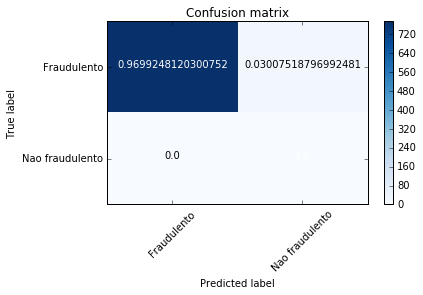

In [65]:
from sklearn.linear_model import RidgeClassifier

clf_rdg = RidgeClassifier(alpha=1.0, 
                          fit_intercept=True, 
                          normalize=True, 
                          copy_X=True, 
                          max_iter=None, 
                          tol=0.001, 
                          class_weight=None, 
                          solver='auto', 
                          random_state=0).fit(X_traincv_res, y_traincv_res)

roc_rdg = clf_eval(clf_rdg, X_testcv, y_testcv)

**Perceptron**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      0.84      0.92       798
    Sobreviveu       0.02      1.00      0.03         2

   avg / total       1.00      0.84      0.91       800

ROC Score: 0.9216791979949875
Accuracy Score: 0.84375
Average Precision Score: 0.015748031496062992
f1 Score: 0.031007751937984496
Confusion matrix, without normalization
[[673 125]
 [  0   2]]


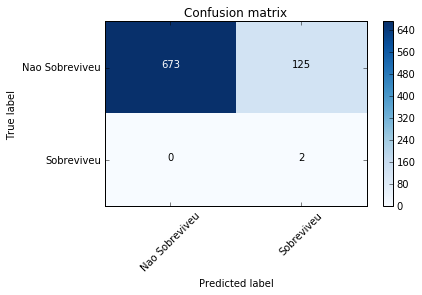

In [31]:
from sklearn.linear_model import Perceptron

clf_pcp = Perceptron(penalty='elasticnet',
                     alpha=0.00001,
                     fit_intercept=True,
                     max_iter=None,
                     shuffle=False,
                     tol = 0.00015,
                     verbose=0,
                     eta0=4.0,
                     n_jobs=-1, 
                     random_state=0, 
                     class_weight=None, 
                     warm_start=False).fit(X_traincv_res, y_traincv_res)

roc_pcp = clf_eval(clf_pcp, X_testcv, y_testcv)

**Passive Agressive**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      0.98      0.99       798
    Sobreviveu       0.12      1.00      0.22         2

   avg / total       1.00      0.98      0.99       800

ROC Score: 0.9912280701754386
Accuracy Score: 0.9825
Average Precision Score: 0.125
f1 Score: 0.2222222222222222
Confusion matrix, without normalization
[[784  14]
 [  0   2]]


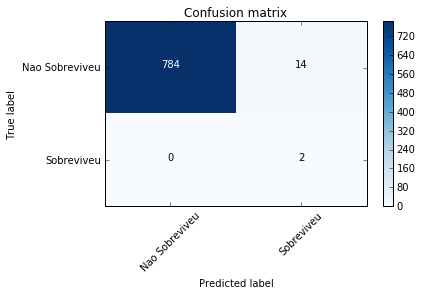

In [32]:
from sklearn.linear_model import PassiveAggressiveClassifier

clf_pac = PassiveAggressiveClassifier(C=0.00015, 
                                      fit_intercept=True, 
                                      max_iter=None,
                                      tol=0.00009,
                                      shuffle=True, 
                                      verbose=0, 
                                      loss='hinge', 
                                      n_jobs=-1, 
                                      random_state=0, 
                                      warm_start=False, 
                                      class_weight=None).fit(X_traincv_res, y_traincv_res)

roc_pac = clf_eval(clf_pac, X_testcv, y_testcv)

**SGDC Classifier**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      0.94      0.97       798
    Sobreviveu       0.04      1.00      0.08         2

   avg / total       1.00      0.94      0.97       800

ROC Score: 0.9692982456140351
Accuracy Score: 0.93875
Average Precision Score: 0.0392156862745098
f1 Score: 0.07547169811320754
Confusion matrix, without normalization
[[749  49]
 [  0   2]]


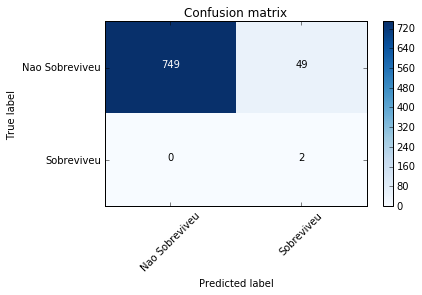

In [36]:
from sklearn.linear_model import SGDClassifier

clf_sgdc = SGDClassifier(loss='huber',
                         penalty='elasticnet', 
                         alpha=0.001,
                         l1_ratio=0.5, 
                         fit_intercept=True,
                         max_iter=None,
                         tol=0.001,
                         shuffle=True,
                         verbose=0,
                         epsilon=0.0099,
                         n_jobs=-1,
                         random_state=0,
                         learning_rate='optimal',
                         eta0=1.0, 
                         power_t=0.5,
                         class_weight=None,
                         warm_start=False, 
                         average=False).fit(X_traincv_res, y_traincv_res)

roc_sgdc = clf_eval(clf_sgdc, X_testcv, y_testcv)

**K-Nearest Neighbors**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      0.99      1.00       798
    Sobreviveu       0.22      1.00      0.36         2

   avg / total       1.00      0.99      0.99       800

ROC Score: 0.9956140350877193
Accuracy Score: 0.99125
Average Precision Score: 0.2222222222222222
f1 Score: 0.3636363636363636
Confusion matrix, without normalization
[[791   7]
 [  0   2]]


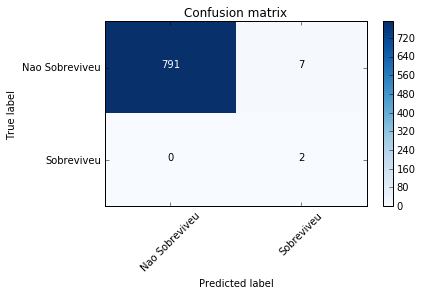

In [37]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier(n_neighbors=30,
                               weights='distance', 
                               algorithm='auto', 
                               leaf_size=30, 
                               p=1, 
                               metric='minkowski', 
                               metric_params=None, 
                               n_jobs=-1).fit(X_traincv_res, y_traincv_res)

roc_knn = clf_eval(clf_knn, X_testcv, y_testcv)

**Decision Tree**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      1.00      1.00       798
    Sobreviveu       0.40      1.00      0.57         2

   avg / total       1.00      1.00      1.00       800

ROC Score: 0.9981203007518796
Accuracy Score: 0.99625
Average Precision Score: 0.4
f1 Score: 0.5714285714285715
Confusion matrix, without normalization
[[795   3]
 [  0   2]]


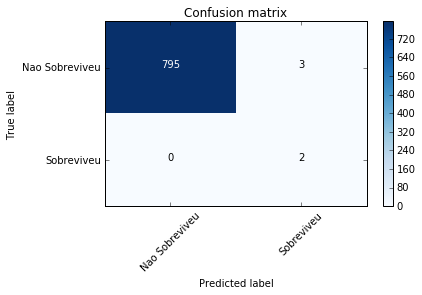

In [38]:
from sklearn.tree import DecisionTreeClassifier

clf_dtc = DecisionTreeClassifier(criterion='gini', 
                                 splitter='best', 
                                 max_depth=4, 
                                 min_samples_split=3, 
                                 min_samples_leaf=1, 
                                 min_weight_fraction_leaf=0.0, 
                                 max_features=None, 
                                 random_state=0, 
                                 max_leaf_nodes=None, 
                                 class_weight=None, 
                                 presort=False).fit(X_traincv_res, y_traincv_res)

roc_dtc = clf_eval(clf_dtc, X_testcv, y_testcv)

**Random Forest**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      1.00      1.00       798
    Sobreviveu       0.50      1.00      0.67         2

   avg / total       1.00      1.00      1.00       800

ROC Score: 0.9987468671679198
Accuracy Score: 0.9975
Average Precision Score: 0.5
f1 Score: 0.6666666666666666
Confusion matrix, without normalization
[[796   2]
 [  0   2]]


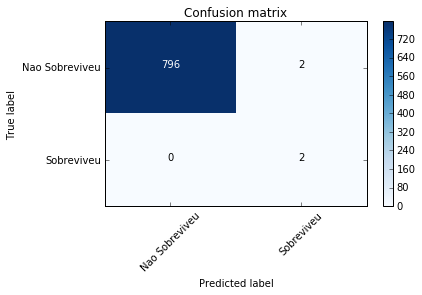

In [39]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=1000, 
                                criterion='gini', 
                                max_depth=3, 
                                min_samples_split=3,
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=0, 
                                verbose=0, 
                                warm_start=False, 
                                class_weight=None).fit(X_traincv_res, y_traincv_res)

roc_rf = clf_eval(clf_rf, X_testcv, y_testcv)

**Bagging**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      1.00      1.00       798
    Sobreviveu       0.33      0.50      0.40         2

   avg / total       1.00      1.00      1.00       800

ROC Score: 0.7487468671679198
Accuracy Score: 0.99625
Average Precision Score: 0.16791666666666666
f1 Score: 0.4
Confusion matrix, without normalization
[[796   2]
 [  1   1]]


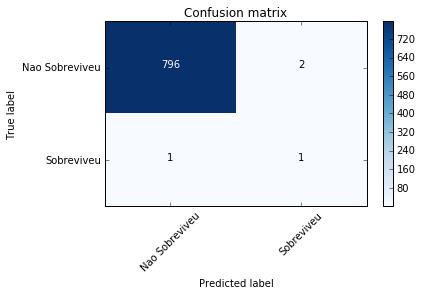

In [45]:
from sklearn.ensemble import BaggingClassifier

clf_bgc = BaggingClassifier(base_estimator=None, 
                            n_estimators=10,
                            max_samples=1.0, 
                            max_features=1.0,
                            bootstrap=True,
                            bootstrap_features=False,
                            oob_score=False,
                            warm_start=True,
                            n_jobs=-1,
                            random_state=0,
                            verbose=0).fit(X_traincv_res, y_traincv_res)

roc_bgc = clf_eval(clf_bgc, X_testcv, y_testcv)

**Extra Trees**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      0.99      1.00       798
    Sobreviveu       0.29      1.00      0.44         2

   avg / total       1.00      0.99      1.00       800

ROC Score: 0.9968671679197996
Accuracy Score: 0.99375
Average Precision Score: 0.2857142857142857
f1 Score: 0.4444444444444445
Confusion matrix, without normalization
[[793   5]
 [  0   2]]


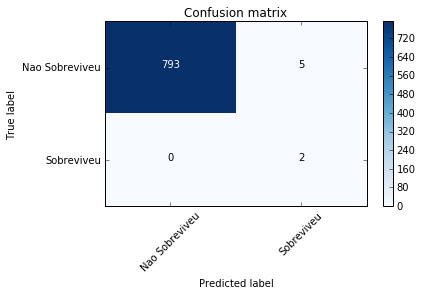

In [47]:
from sklearn.ensemble import ExtraTreesClassifier

clf_etc = ExtraTreesClassifier(n_estimators=500,
                               max_depth=10,
                               min_samples_split=3,
                               random_state=0,
                               n_jobs=-1).fit(X_traincv_res, y_traincv_res)

roc_etc = clf_eval(clf_etc, X_testcv, y_testcv)

**Boosting**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      0.94      0.97       798
    Sobreviveu       0.04      1.00      0.08         2

   avg / total       1.00      0.94      0.97       800

ROC Score: 0.9705513784461153
Accuracy Score: 0.94125
Average Precision Score: 0.04081632653061224
f1 Score: 0.07843137254901959
Confusion matrix, without normalization
[[751  47]
 [  0   2]]


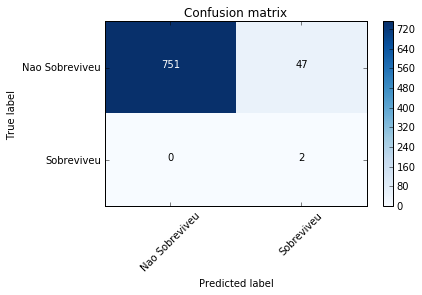

In [48]:
from sklearn.ensemble import AdaBoostClassifier

clf_abc = AdaBoostClassifier(base_estimator=None,
                             n_estimators=20,
                             learning_rate=0.1,
                             algorithm='SAMME',
                             random_state=0).fit(X_traincv_res, y_traincv_res)

roc_abc = clf_eval(clf_abc, X_testcv, y_testcv)

**Bayesian Classifiers**

*Gaussiano*

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      0.99      0.99       798
    Sobreviveu       0.10      0.50      0.17         2

   avg / total       1.00      0.99      0.99       800

ROC Score: 0.7443609022556392
Accuracy Score: 0.9875
Average Precision Score: 0.051250000000000004
f1 Score: 0.16666666666666669
Confusion matrix, without normalization
[[789   9]
 [  1   1]]


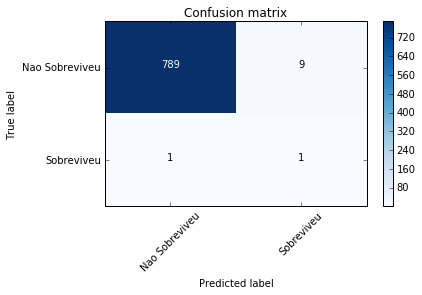

In [49]:
from sklearn.naive_bayes import GaussianNB

clf_gnb = GaussianNB().fit(X_traincv_res, y_traincv_res)

roc_gnb = clf_eval(clf_gnb, X_testcv, y_testcv)

*Bernoulli*

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      0.99      0.99       798
    Sobreviveu       0.18      1.00      0.31         2

   avg / total       1.00      0.99      0.99       800

ROC Score: 0.9943609022556391
Accuracy Score: 0.98875
Average Precision Score: 0.18181818181818182
f1 Score: 0.3076923076923077
Confusion matrix, without normalization
[[789   9]
 [  0   2]]


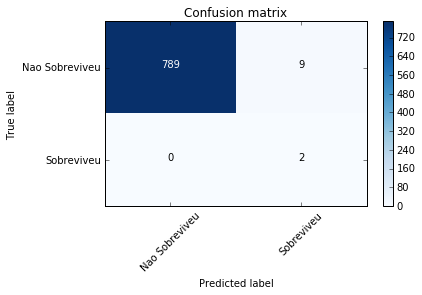

In [50]:
from sklearn.naive_bayes import BernoulliNB

clf_bnb = BernoulliNB(alpha=0.0001, 
                     binarize=0.0, 
                     fit_prior=True, 
                     class_prior=None).fit(X_traincv_res, y_traincv_res)

roc_bnb = clf_eval(clf_bnb, X_testcv, y_testcv)

**Gaussian Process**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      0.99      1.00       798
    Sobreviveu       0.25      1.00      0.40         2

   avg / total       1.00      0.99      0.99       800

ROC Score: 0.9962406015037594
Accuracy Score: 0.9925
Average Precision Score: 0.25
f1 Score: 0.4
Confusion matrix, without normalization
[[792   6]
 [  0   2]]


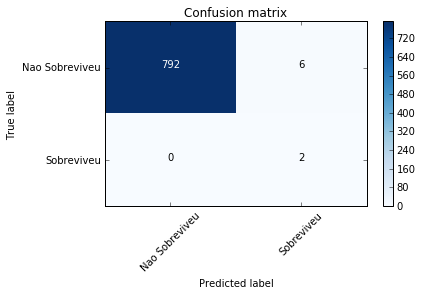

In [51]:
from sklearn.gaussian_process import GaussianProcessClassifier


clf_gpc = GaussianProcessClassifier(kernel=None, 
                                    optimizer='fmin_l_bfgs_b', 
                                    n_restarts_optimizer=0, 
                                    max_iter_predict=100, 
                                    warm_start=False, 
                                    copy_X_train=True, 
                                    random_state=0, 
                                    multi_class='one_vs_rest', 
                                    n_jobs=-1).fit(X_traincv_res, y_traincv_res)

roc_gpc = clf_eval(clf_gpc, X_testcv, y_testcv)

**Neural Network**

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


6388 train samples
800 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               166200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 24) 

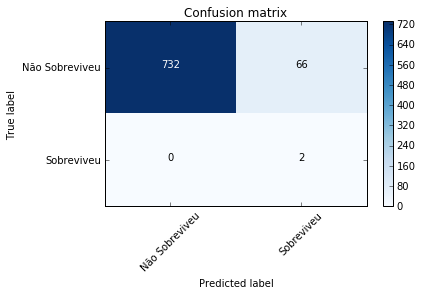

In [52]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, RMSprop
from keras.utils.np_utils import to_categorical

x_train_kr = X_traincv_res.astype('float32') 
x_test_kr = X_testcv.astype('float32')

print(x_train_kr.shape[0], 'train samples')
print(x_test_kr.shape[0], 'test samples')

y_train_kr = y_traincv_res
y_test_kr = y_testcv

# convert class vectors to binary class matrices for categorical cross_entropy
#y_train_kr = to_categorical(y_traincv)
#y_test_kr = to_categorical(y_testcv)

batch_size = int(len(x_test_kr)/15)
num_classes = 2
epochs = 15
np.random.seed(0)

model = Sequential()
model.add(Dense(input_dim=x_train_kr.shape[1], units=300, activation='relu'))
model.add(Dropout(0.10))
model.add(Dense(input_dim=300, units=300, activation='relu'))
model.add(Dropout(0.10))
model.add(Dense(input_dim=300, units=200, activation='relu'))
model.add(Dropout(0.10))
model.add(Dense(input_dim=200, units=24, activation='relu')) #activation='softmax'
model.add(Dropout(0.10))
model.add(Dense(input_dim=24,  units=1, activation='sigmoid')) #kernel_initializer='uniform',
model.summary()


model.compile(loss='binary_crossentropy',
              #loss='categorical_crossentropy',
              #loss='mean_squared_error',
              #optimizer='adam',
              #optimizer=RMSprop(), 
              optimizer=SGD(lr=0.001),
              metrics=['binary_accuracy'])

history = model.fit(x_train_kr, y_train_kr,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=False,
                    validation_data=(x_test_kr, y_test_kr))

score = model.evaluate(x_test_kr, y_test_kr, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


y_pred = model.predict_classes(x_test_kr)
clf_matrix = confusion_matrix(y_test_kr, y_pred)
print('Classification Report')
print(classification_report(y_test_kr, y_pred, target_names=['Não Sobreviveu', 'Sobreviveu']))
print('ROC Score: {}'.format(roc_auc_score(y_test_kr, y_pred)))
print('Accuracy Score: {}'.format(accuracy_score(y_test_kr, y_pred)))
print('Average Precision Score: {}'.format(average_precision_score(y_test_kr, y_pred)))
print('f1 Score: {}'.format(f1_score(y_test_kr, y_pred)))
plot_confusion_matrix(clf_matrix, classes=['Não Sobreviveu', 'Sobreviveu'])
roc_keras = roc_auc_score(y_test_kr, y_pred)

**Resultados**
-----------

Agora, precisamos analisar a AUC da ROC de todos os modelos testados e fazer uma comparação.

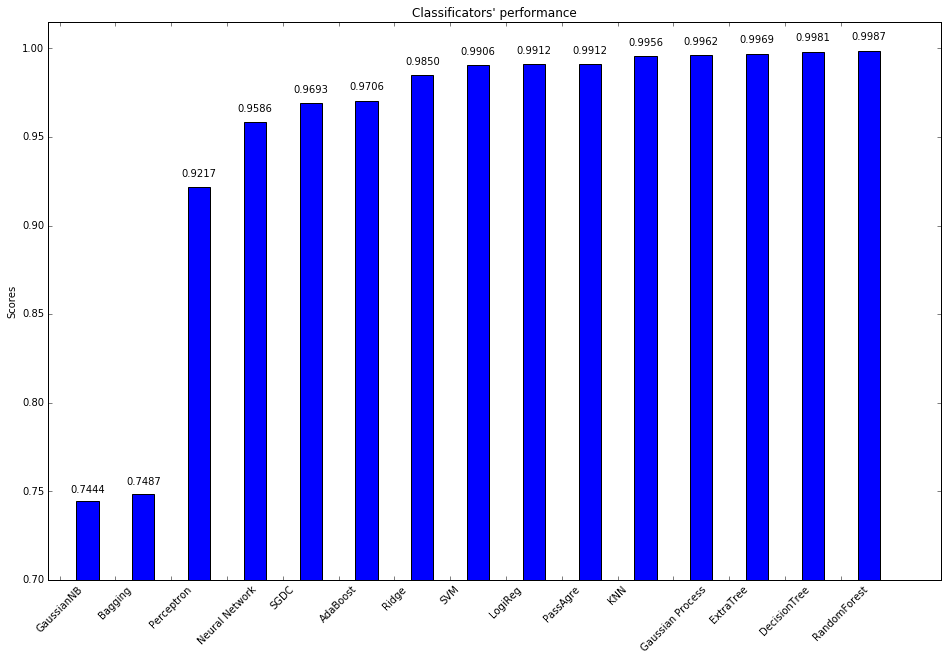

In [59]:
dic_results = {'SVM': roc_svc2,
               'LogiReg': roc_lr,
               'Ridge': roc_rdg,
               'Perceptron': roc_pcp,
               'PassAgre': roc_pac,
               'SGDC': roc_sgdc,
               'KNN':roc_knn,
               'DecisionTree': roc_dtc,
               'RandomForest': roc_rf,
               'Bagging': roc_bgc,
               'ExtraTree': roc_etc,
               'AdaBoost': roc_abc,
               'GaussianNB': roc_gnb,
               'Gaussian Process': roc_gpc,
               'Neural Network': roc_keras
              }

import operator
tup_results = sorted(dic_results.items(), key=operator.itemgetter(1))

N = len(dic_results)
ind = np.arange(N)  # the x locations for the groups
width = 0.40       # the width of the bars

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
rects = ax.bar(ind+0.5, list(zip(*tup_results))[1], width,)
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2., 
            1.005*height, 
            '{0:.4f}'.format(height), 
            ha='center', 
            va='bottom',)

ax.set_ylabel('Scores')
ax.set_ylim(ymin=0.7,ymax = 1.015)
ax.set_title("Classificators' performance")
ax.set_xticks(ind + width/2.)
ax.set_xticklabels(list(zip(*tup_results))[0], rotation=45)

plt.show()

O melhor classificador foi **Random Forest**. Vamos utilizá-lo agora no conjunto de testes e prepará-lo para submissão. Gerou-se uma planilha em csv com os valores preditos pelo modelo no conjunto de testes.

In [60]:
import csv

#output = clf_rgf.predict(X_test)

output = [1,0,0,0,0,1,1,0,0,1]
N = len(output)
a = ['click_id']
a.extend(range(N))

b = ['is_attributed']
b.extend(output)

rows = zip(a,b)
with open('sampleSubmission.csv','w') as f:
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)